In [48]:
# pip install --user ipykernel
# python -m ipykernel install --user --name=myenv
import csv
import tqdm
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 20
batch_size = 32
learning_rate = 1e-3
context_frames = 10
sequence_length = 20
lookback = sequence_length

context_epochs = 20
context_batch_size = 1
context_learning_rate = 1e-3
context_data_length = 20

valid_train_split = 0.8  # precentage of train data from total
test_train_split = 0.9  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available


In [49]:
class BatchGenerator:
    def __init__(self, data_dir, logger):
        self.data_dir = data_dir
        data_map = []
        with open(data_dir + 'map.csv', 'r') as f:  # rb
            reader = csv.reader(f)
            for row in reader:
                data_map.append(row)

        if len(data_map) <= 1: # empty or only header
            logger.error("No file map found")
            exit()

        self.data_map = data_map

    def load_full_data(self):
        dataset_train = FullDataSet(self.data_dir, self.data_map, type_="train")
        dataset_valid = FullDataSet(self.data_dir, self.data_map, type_="valid")
        dataset_test = FullDataSet(self.data_dir, self.data_map, type_="test")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader


class FullDataSet():
    def __init__(self, data_dir, data_map, type_="train"):
        dataset_full = []
        for index, value in enumerate(data_map[1:]):  # ignore header
            state = np.float32(np.load(data_dir + '/' + value[4]))
            dataset_full.append([np.load(data_dir + value[8]),
                                 np.float32(np.load(data_dir + '/' + value[2])),
                                 np.float32(np.load(data_dir + '/' + value[3])),
                                 np.asarray([state[0] for i in range(0, len(state))])])
        if type_ == "train":
            self.samples = dataset_full[0:int(len(dataset_full)*test_train_split)]
        elif type_ == "valid":
            self.samples = dataset_full[int(len(dataset_full)*(valid_train_split)):int(len(dataset_full)*test_train_split)]
        elif type_ == "test":
            self.samples = dataset_full[int(len(dataset_full)*test_train_split):-1]

        data_map = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        return(self.samples[idx])

data_dir = '/home/user/Robotics/Data_sets/slip_detection/vector_normalised_002/'
logger = logging.getLogger(__name__)

BG = BatchGenerator(data_dir, logger)
print("done")

done


In [50]:
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(48, 48).to(device)  # tactile
        self.lstm2 = nn.LSTM(6, 6).to(device)  # pos_vel
        self.fc1 = nn.Linear(48+6, 48)  # tactile + pos_vel
        self.lstm3 = nn.LSTM(48, 48).to(device)  # pos_vel

    def forward(self, tactiles, actions):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        hidden2 = (torch.rand(1,batch_size__,6).to(device), torch.rand(1,batch_size__,6).to(device))
        hidden3 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        for index, (sample_tactile, sample_action) in enumerate(zip(tactiles.squeeze(), actions.squeeze())):
            sample_tactile.to(device)
            sample_action.to(device)
            # 2. Run through lstm:
            if index > context_frames-1:
                out1, hidden1 = self.lstm1(out4, hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)
                outputs.append(out4.squeeze())
            else:
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(sample_action.unsqueeze(0), hidden2)
                robot_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(robot_and_tactile.unsqueeze(0).cpu().detach())
                out4, hidden3 = self.lstm3(out3.to(device), hidden3)

        return torch.stack(outputs)


In [53]:
class ModelTrainer:
    def __init__(self, logger, data_dir):
        self.data_dir = data_dir
        ### Train the LSTM chain:
        self.train_full_loader, self.valid_full_loader, self.test_full_loader = BG.load_full_data()
        self.full_model = FullModel()
        self.criterion = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        plot_training_loss = []
        plot_validation_loss = []
        previous_val_mean_loss = 1.0
        early_stop_clock = 0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                tactile = batch_features[1].permute(1,0,2).to(device)
                action = batch_features[2].permute(1,0,2).to(device)
                state = batch_features[3].permute(1,0,2).to(device)
                
                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action) # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                loss = self.criterion(tactile_predictions.to(device), tactile[context_frames:])
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            plot_training_loss.append(mean)

            val_losses = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_full_loader):
                    tactile = batch_features[1].permute(1,0,2).to(device)
                    action = batch_features[2].permute(1,0,2).to(device)
                    state = batch_features[3].permute(1,0,2).to(device)

                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action)  # Step 3. Run our forward pass.
                    self.optimizer.zero_grad()
                    val_loss = self.criterion(tactile_predictions.to(device), tactile[context_frames:])
                    val_losses += val_loss.item()

            print("Validation mean loss: {:.4f}, ".format(val_losses / index__))
            plot_validation_loss.append(val_losses / index__)
            if previous_val_mean_loss < val_losses / index__:
                early_stop_clock +=1
                if early_stop_clock == 3:
                    print("Early stopping")
                    break
            else:
                previous_val_mean_loss = val_losses / index__ 
        plt.plot(plot_training_loss, c="r", label="train loss MAE")
        plt.plot(plot_validation_loss, c='b', label="val loss MAE")
        plt.legend(loc="upper right")

MT = ModelTrainer(logger, data_dir)
print("done")

done


epoch: 1, loss: 0.0166, mean loss: 0.0190, :   5%|▌         | 727/14340 [00:13<09:40, 23.43it/s]

Validation mean loss: 0.0175, 


epoch: 2, loss: 0.0095, mean loss: 0.0100, :  10%|█         | 1444/14340 [00:26<11:22, 18.91it/s]

Validation mean loss: 0.0098, 


epoch: 3, loss: 0.0074, mean loss: 0.0102, :  15%|█▌        | 2161/14340 [00:40<08:35, 23.63it/s]

Validation mean loss: 0.0088, 


epoch: 4, loss: 0.0075, mean loss: 0.0091, :  20%|██        | 2878/14340 [00:53<10:09, 18.82it/s]

Validation mean loss: 0.0083, 


epoch: 5, loss: 0.0059, mean loss: 0.0083, :  25%|██▌       | 3595/14340 [01:07<07:34, 23.65it/s]

Validation mean loss: 0.0077, 


epoch: 6, loss: 0.0066, mean loss: 0.0084, :  30%|███       | 4318/14340 [01:20<06:26, 25.96it/s]

Validation mean loss: 0.0080, 


epoch: 7, loss: 0.0076, mean loss: 0.0074, :  35%|███▌      | 5035/14340 [01:33<06:37, 23.39it/s]

Validation mean loss: 0.0071, 


epoch: 8, loss: 0.0064, mean loss: 0.0079, :  40%|████      | 5752/14340 [01:46<07:31, 19.04it/s]

Validation mean loss: 0.0079, 


epoch: 9, loss: 0.0061, mean loss: 0.0070, :  45%|████▌     | 6469/14340 [02:00<05:29, 23.91it/s]

Validation mean loss: 0.0069, 


epoch: 9, loss: 0.0061, mean loss: 0.0069, :   0%|          | 9/14340 [02:13<58:52:45, 14.79s/it]

Validation mean loss: 0.0076, 
Early stopping
done


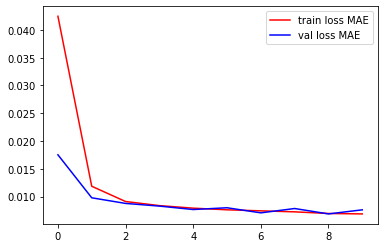

In [54]:
MT.train_full_model()
print("done")

In [56]:
model = MT.full_model
data_dir = MT.data_dir
test_loader = MT.test_full_loader

data_map = []
with open(data_dir + 'map.csv', 'r') as f:  # rb
    reader = csv.reader(f)
    for row in reader:
        data_map.append(row)

if len(data_map) <= 1: # empty or only header
    logger.error("No file map found")
    exit()

# test model on the full test sample:
criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(dataset_sample, batch_size=15, shuffle=False)
tactile_predictions = []
tactile_groundtruth = []
test_lossesMAE = 0.0
test_lossesMSE = 0.0
with torch.no_grad():
    for index__, batch_features in enumerate(test_loader):
        # 2. Reshape data and send to device:
        tactile = batch_features[1].permute(1,0,2).to(device)
        action = batch_features[2].permute(1,0,2).to(device)
        state = batch_features[3].permute(1,0,2).to(device)

        tp = model.forward(tactiles=tactile, actions=action)
        tactile_predictions.append(tp)  # Step 3. Run our forward pass.
        tactile_groundtruth.append(tactile[context_frames:])
        # calculate losses
        test_lossMAE = criterion1(tp.to(device), tactile[context_frames:])
        test_lossesMAE += test_lossMAE.item()
        test_lossMSE = criterion2(tp.to(device), tactile[context_frames:])
        test_lossesMSE += test_lossMSE.item()

print("test loss MAE(L1): ", str(test_lossesMAE / index__))
print("test loss MSE: ", str(test_lossesMSE / index__))

test loss MAE(L1):  0.008138017728924751
test loss MSE:  0.00037138887380680464


In [59]:
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t9 = 5
predicted_data_t1 = []
predicted_data_t9 = []
groundtruth_data = []
for index, batch_set in enumerate(tactile_predictions):
    for batch in range(0, len(batch_set[0])):
        prediction_values = batch_set[time_step_to_test_t1][batch]
        predicted_data_t1.append(prediction_values)
        prediction_values = batch_set[time_step_to_test_t9][batch]
        predicted_data_t9.append(prediction_values)
        gt_values = tactile_groundtruth[index][time_step_to_test_t1][batch]
        groundtruth_data.append(gt_values)            

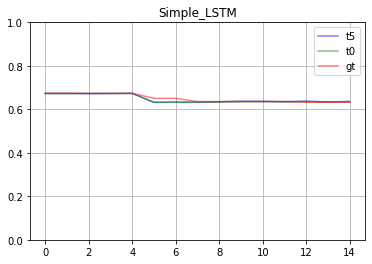

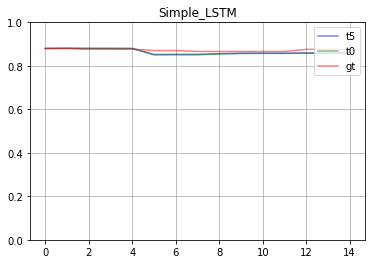

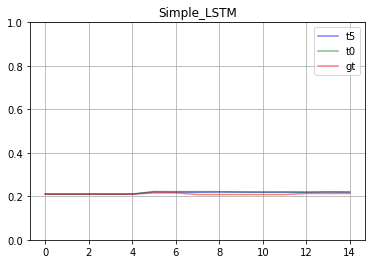

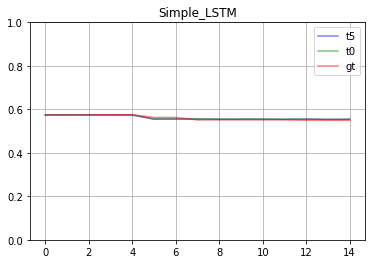

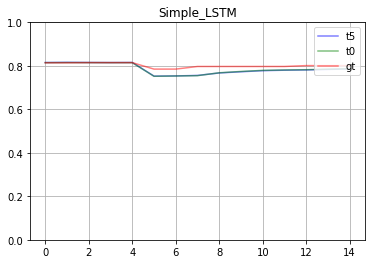

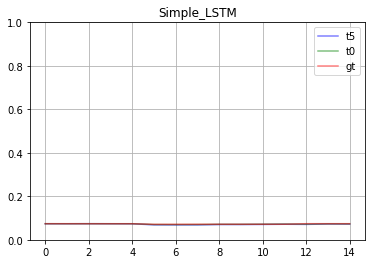

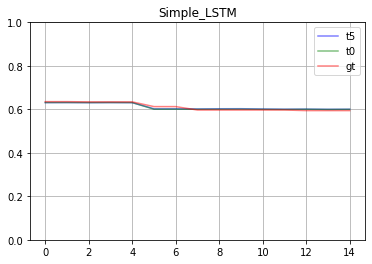

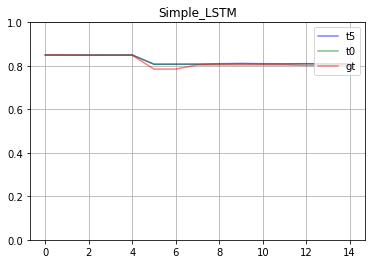

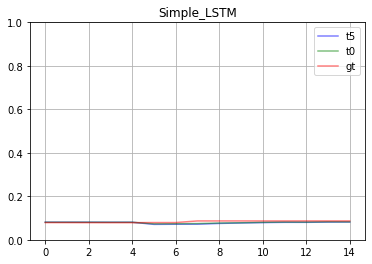

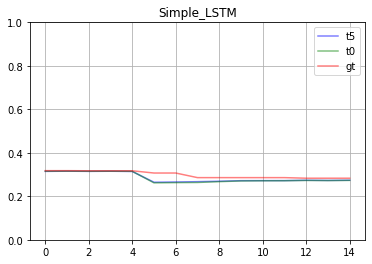

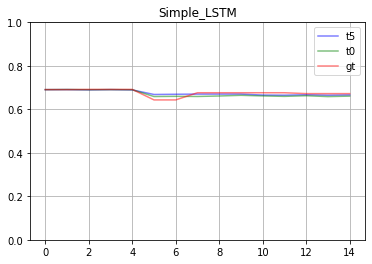

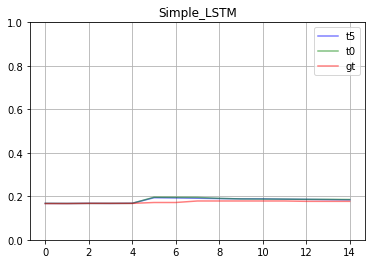

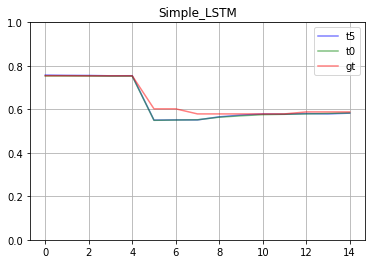

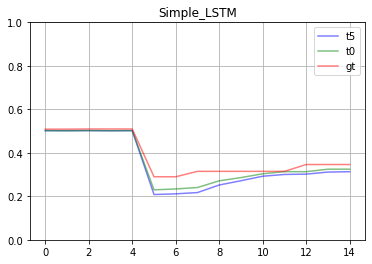

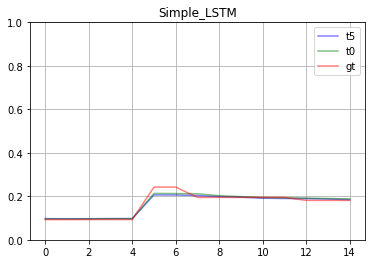

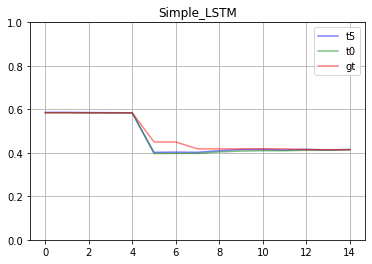

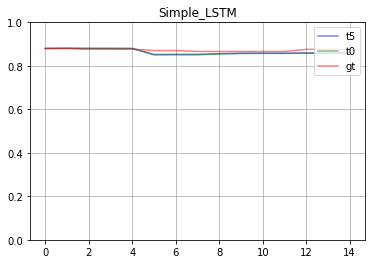

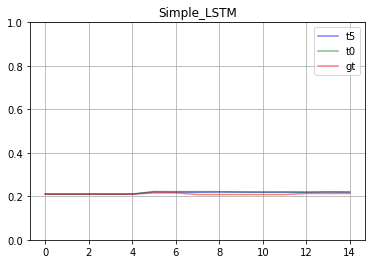

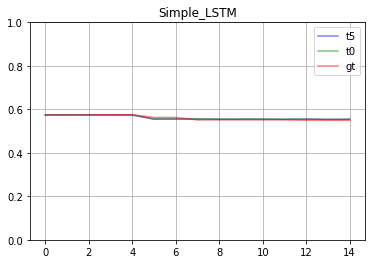

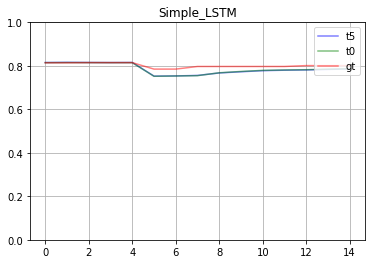

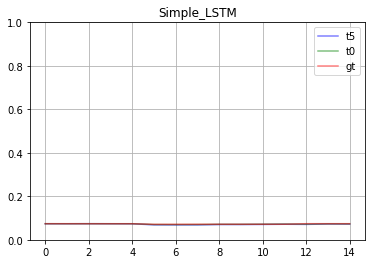

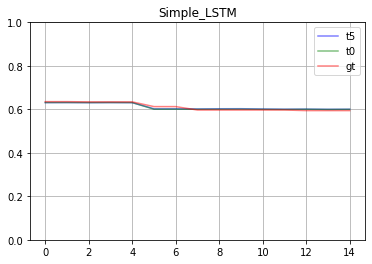

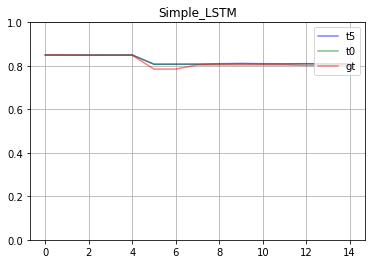

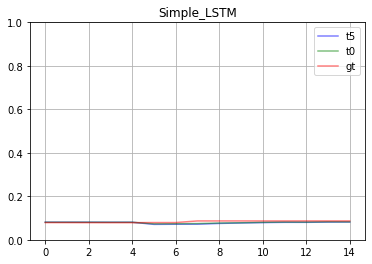

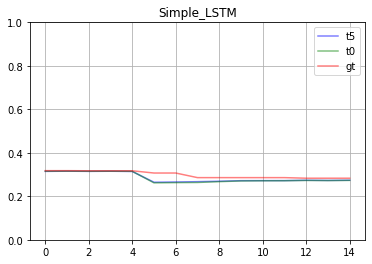

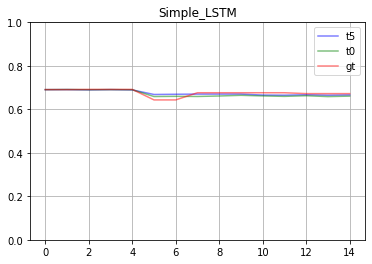

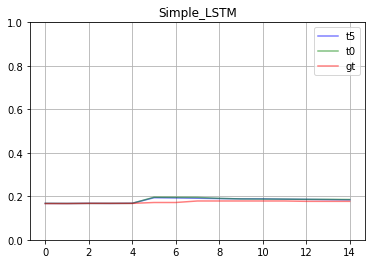

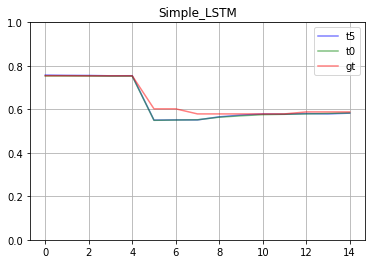

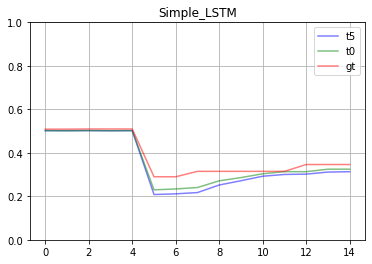

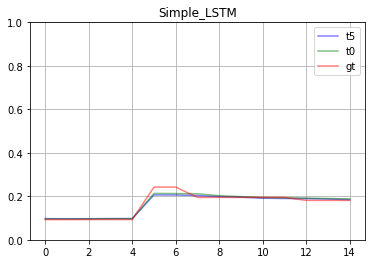

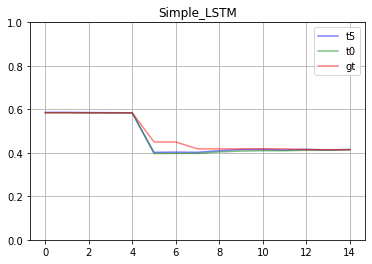

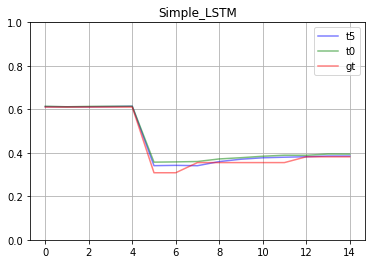

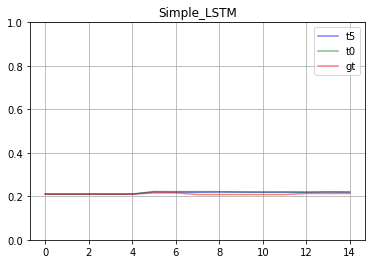

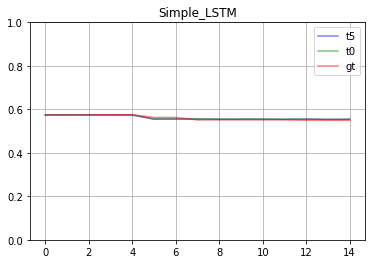

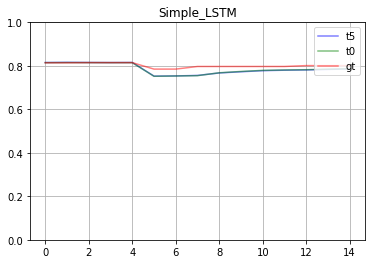

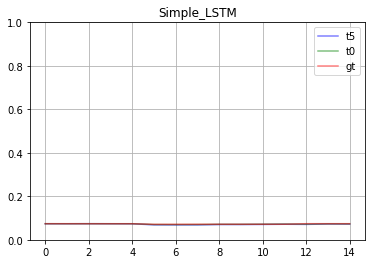

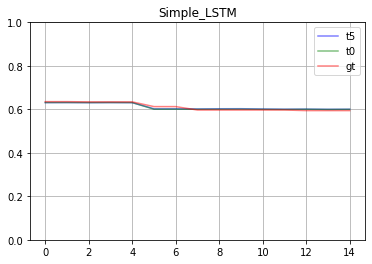

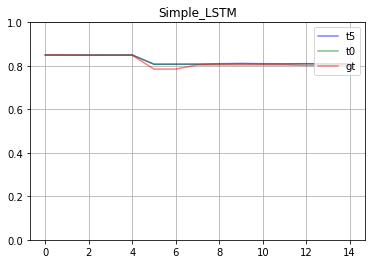

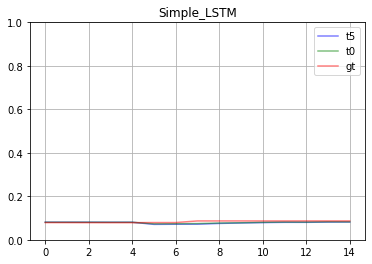

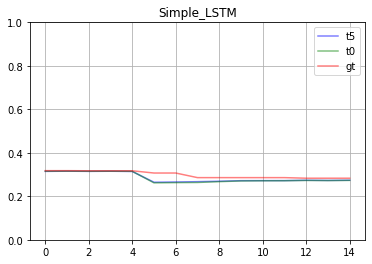

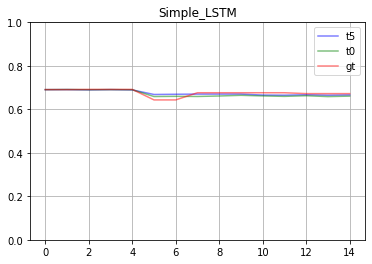

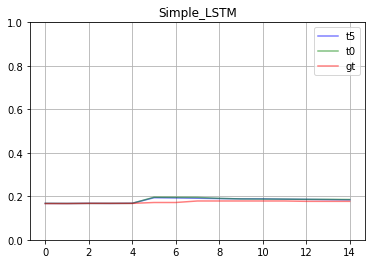

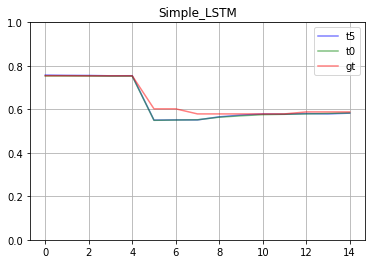

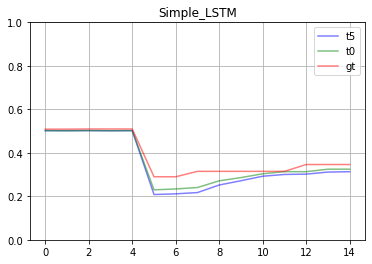

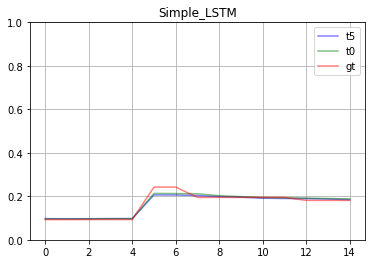

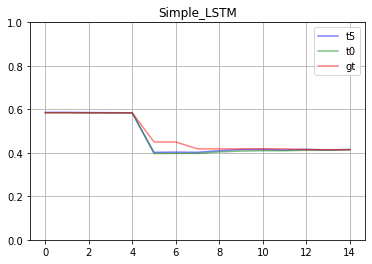

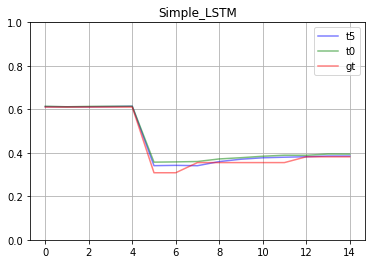

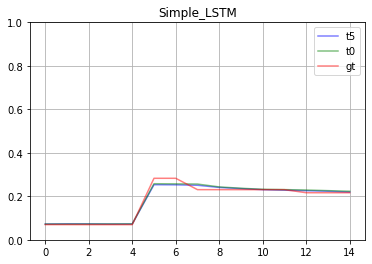

In [61]:
# test data
index = 0
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t9 = []
        for k in range(310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][j+i].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][j+i].cpu().detach().numpy())
            groundtruth_taxle.append(groundtruth_data[k][j+i].cpu().detach().numpy())

        index += 1
        plt.title("Simple_LSTM")
        plt.plot(predicted_taxel_t1, alpha=0.5, c="b", label="t5")
        plt.plot(predicted_taxel_t9, alpha=0.5, c="g", label="t0")
        plt.plot(groundtruth_taxle, alpha=0.5, c="r", label="gt")
        plt.ylim([0, 1])
        plt.grid()
        plt.legend(loc="upper right")
        plt.savefig('/home/user/Robotics/slip_detection_model/images/Simple_LSTM_new_data/simple_model_test_sample_' + str(index) + '.png')
        plt.show()